# Final Presentation Notebook
By: Shateesh Bhugwansing
### Perform my classification experiments from the semester on the entire data set

Classifier: ~~Linear SVM~~ Logistic Regression
1. Audio vs. Visual
2. Language vs. Non language

##### NOTE: Run this on the CCNY Computing Node 

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
%matplotlib inline 


In [2]:
# Emmanuil converted the data into larger, 2GB chunks that we can use at a time. 

epoch_path_1 = '/home/eproj/scratch/LARGE_EPOCH_OBJECTS/large_epoch_1_epo.fif' 
epoch_path_2 = '/home/eproj/scratch/LARGE_EPOCH_OBJECTS/large_epoch_2_epo.fif'
epoch_path_3 = '/home/eproj/scratch/LARGE_EPOCH_OBJECTS/large_epoch_3_epo.fif'
epoch_path_4 = '/home/eproj/scratch/LARGE_EPOCH_OBJECTS/large_epoch_4_epo.fif'
epoch_path_5 = '/home/eproj/scratch/LARGE_EPOCH_OBJECTS/large_epoch_5_epo.fif'

In [ ]:
epoch_path = [epoch_path_1, epoch_path_2, epoch_path_3, epoch_path_4, epoch_path_5]

In [ ]:
# epoch1 = mne.read_epochs(epoch_path_1, preload=True)
# epoch2 = mne.read_epochs(epoch_path_2, preload=True)
# epoch3 = mne.read_epochs(epoch_path_3, preload=True)
# epoch4 = mne.read_epochs(epoch_path_4, preload=True)
# epoch5 = mne.read_epochs(epoch_path_5, preload=True)

In [ ]:
epoch1 = mne.read_epochs(epoch_path_1)
epoch2 = mne.read_epochs(epoch_path_2)
epoch3 = mne.read_epochs(epoch_path_3)
epoch4 = mne.read_epochs(epoch_path_4)
epoch5 = mne.read_epochs(epoch_path_5)

In [6]:
epoch1 = mne.read_epochs(epoch_path_1)

Reading /home/eproj/scratch/LARGE_EPOCH_OBJECTS/large_epoch_1_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
8103 matching events found
Applying baseline correction (mode: mean)
Reading /home/eproj/scratch/LARGE_EPOCH_OBJECTS/large_epoch_1_epo-1.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
8103 matching events found
Applying baseline correction (mode: mean)
16206 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [ ]:
# epoch = mne.epochs.concatenate_epochs([epoch1, epoch2, epoch3])

In [7]:
epoch1.drop_channels(['LL4', 'L12','Nasium', 'VEOG'])

<EpochsFIF  |   16206 events (all good), 0 - 0.5 sec, baseline [0, 0], ~3.88 GB, data loaded,
 'AALL': 1458
 'AALN': 1473
 'AANL': 1227
 'AANN': 1347
 'AVLL': 1422
 'AVNN': 1488
 'VALL': 1413
 'VANN': 1296
 'VVLL': 1113
 'VVLN': 1512
 'VVNL': 1125
 'VVNN': 1332>

In [ ]:
# remove missing channels 'LL4', 'L12'
epoch.drop_channels(['LL4', 'L12'])


## Experiment 1 : Audio vs. Visual, Logistic Regression
Using MNE Sliding estimator  
example found here : https://mne-tools.github.io/0.16/auto_tutorials/plot_sensors_decoding.html

In [8]:
### epoch object has been updated with events that can be used for classification
# epoch.events[:,-1] < 700 = audio  
# epoch.events[:,-1] > 700 = visual

In [9]:
# create a labels array
# let 0 = audio, 1 = visual

labels = [0 if (x < 700) else 1 for x in epoch1.events[:,-1]]

In [10]:
labels_np = np.array(labels)

In [11]:
len(labels_np)

16206

In [12]:
# get imports used for classification algos 

from mne.decoding import Vectorizer, get_coef
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout

In [13]:
data = epoch1.get_data()

In [15]:
from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)

[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


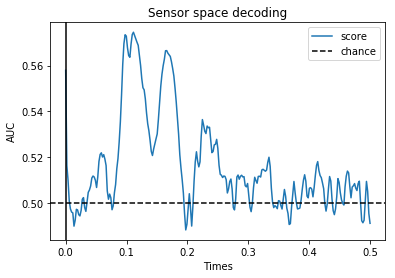

In [22]:
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=5000))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')

scores = cross_val_multiscore(time_decod, data, labels_np, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epoch1.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

[........................................] 100.00% Fitting SlidingEstimator |  


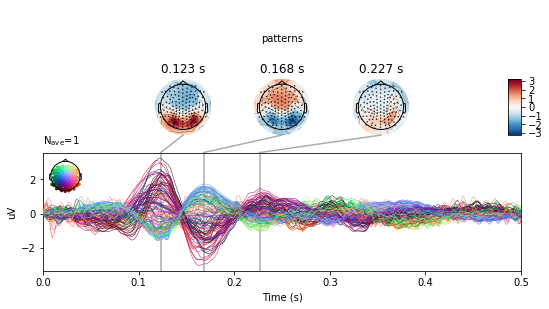

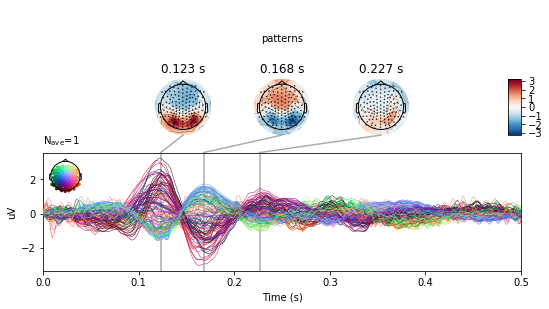

In [27]:
# You can retrieve the spatial filters and spatial patterns if you explicitly
# use a LinearModel
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression(solver='lbfgs', max_iter=5000)))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
time_decod.fit(data, labels_np)


coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epoch1.info, tmin=epoch1.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked.plot_joint(title='patterns',
                  **joint_kwargs)

## Experiment 2: Language vs. Non Language, Logistic Regression 
Using MNE Sliding Estimator 


In [30]:
language = [112, 312, 512, 712, 912, 1112]
non_language = [212, 412, 612, 812, 1012, 1212]

labels2 = [0 if (x in language) else 1 for x in epoch1.events[:,-1]]

In [31]:
labels2_np = np.array(labels2)

In [34]:
clf2 = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=5000))

time_decod2 = SlidingEstimator(clf2, n_jobs=1, scoring='roc_auc')

scores2 = cross_val_multiscore(time_decod, data, labels2_np, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores2 = np.mean(scores2, axis=0)

MemoryError: 